In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/test-cases/s3.UseCase.csv
/kaggle/input/test-cases/S1. Curated Input.csv
/kaggle/input/test-cases/S2. Example Input.csv
/kaggle/input/test-cases/S4Example.csv
/kaggle/input/xai-dataset-2/clinical_mastitis_cows.csv
/kaggle/input/xai-dataset-2/S1. Curated Input_v1.csv


In [2]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import shap

2024-06-30 20:54:17.996113: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-30 20:54:17.996242: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-30 20:54:18.149984: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Load the dataset
file_path = "/kaggle/input/xai-dataset-2/S1. Curated Input_v1.csv"  # Update with the correct path
df = pd.read_csv(file_path)

In [4]:
from sklearn.preprocessing import MinMaxScaler

# Load dataset 

df = df.drop(columns=[ 'ID'])
df = pd.get_dummies(df)

df

,Months_after_giving_birth,IUFL,EUFL,IUFR,EUFR,IURL,EURL,IURR,EURR,Temperature,Health_Healthy,Health_Mastitis
0,1,150,180,150,180,150,181,150,181,43,False,True
1,1,152,180,152,185,151,180,152,181,42,True,False
2,1,152,182,153,186,151,186,153,183,41,True,False
3,1,155,183,155,189,155,182,155,186,40,True,False
4,1,150,186,150,181,150,185,150,188,41,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
7993,5,153,174,156,175,155,177,153,177,41,True,False
7994,2,241,278,235,282,234,277,238,281,41,True,False
7995,5,157,173,157,174,156,174,158,168,41,True,False
7996,3,172,196,163,191,162,192,165,194,41,True,False


In [5]:
df['Health_Healthy'] = df['Health_Healthy'].apply(lambda x: 1 if x else 0)
df['Health_Mastitis'] = df['Health_Mastitis'].apply(lambda x: 1 if x else 0)


df

,Months_after_giving_birth,IUFL,EUFL,IUFR,EUFR,IURL,EURL,IURR,EURR,Temperature,Health_Healthy,Health_Mastitis
0,1,150,180,150,180,150,181,150,181,43,0,1
1,1,152,180,152,185,151,180,152,181,42,1,0
2,1,152,182,153,186,151,186,153,183,41,1,0
3,1,155,183,155,189,155,182,155,186,40,1,0
4,1,150,186,150,181,150,185,150,188,41,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7993,5,153,174,156,175,155,177,153,177,41,1,0
7994,2,241,278,235,282,234,277,238,281,41,1,0
7995,5,157,173,157,174,156,174,158,168,41,1,0
7996,3,172,196,163,191,162,192,165,194,41,1,0


In [6]:
df= df.drop('Health_Healthy', axis=1)
df

,Months_after_giving_birth,IUFL,EUFL,IUFR,EUFR,IURL,EURL,IURR,EURR,Temperature,Health_Mastitis
0,1,150,180,150,180,150,181,150,181,43,1
1,1,152,180,152,185,151,180,152,181,42,0
2,1,152,182,153,186,151,186,153,183,41,0
3,1,155,183,155,189,155,182,155,186,40,0
4,1,150,186,150,181,150,185,150,188,41,0
...,...,...,...,...,...,...,...,...,...,...,...
7993,5,153,174,156,175,155,177,153,177,41,0
7994,2,241,278,235,282,234,277,238,281,41,0
7995,5,157,173,157,174,156,174,158,168,41,0
7996,3,172,196,163,191,162,192,165,194,41,0


In [7]:
y = df['Health_Mastitis'].values


x = df.drop('Health_Mastitis', axis=1)
x.info()
x

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7998 entries, 0 to 7997
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Months_after_giving_birth  7998 non-null   int64
 1   IUFL                       7998 non-null   int64
 2   EUFL                       7998 non-null   int64
 3   IUFR                       7998 non-null   int64
 4   EUFR                       7998 non-null   int64
 5   IURL                       7998 non-null   int64
 6   EURL                       7998 non-null   int64
 7   IURR                       7998 non-null   int64
 8   EURR                       7998 non-null   int64
 9   Temperature                7998 non-null   int64
dtypes: int64(10)
memory usage: 625.0 KB


,Months_after_giving_birth,IUFL,EUFL,IUFR,EUFR,IURL,EURL,IURR,EURR,Temperature
0,1,150,180,150,180,150,181,150,181,43
1,1,152,180,152,185,151,180,152,181,42
2,1,152,182,153,186,151,186,153,183,41
3,1,155,183,155,189,155,182,155,186,40
4,1,150,186,150,181,150,185,150,188,41
...,...,...,...,...,...,...,...,...,...,...
7993,5,153,174,156,175,155,177,153,177,41
7994,2,241,278,235,282,234,277,238,281,41
7995,5,157,173,157,174,156,174,158,168,41
7996,3,172,196,163,191,162,192,165,194,41


col:  Months_after_giving_birth


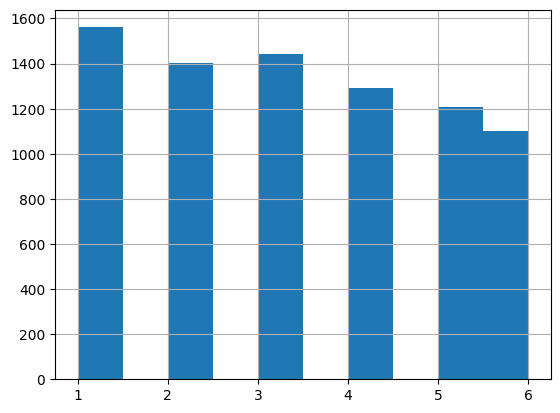

col:  IUFL


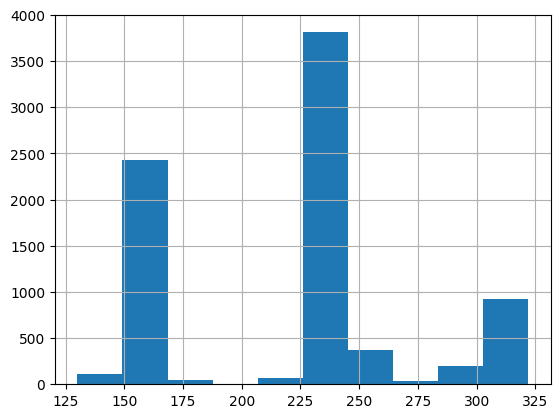

col:  EUFL


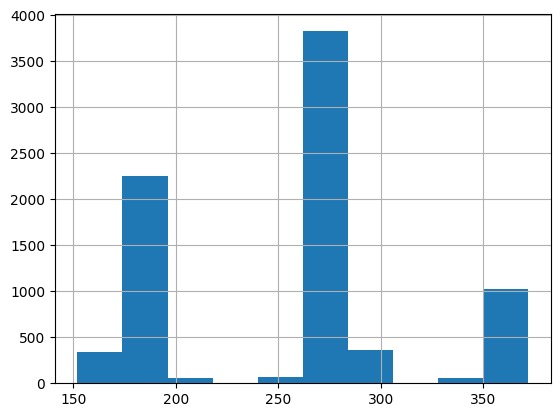

col:  IUFR


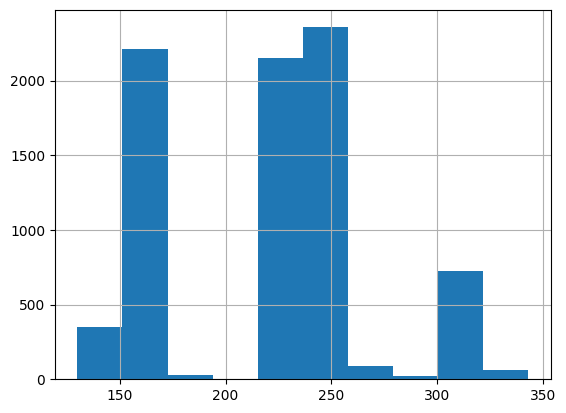

col:  EUFR


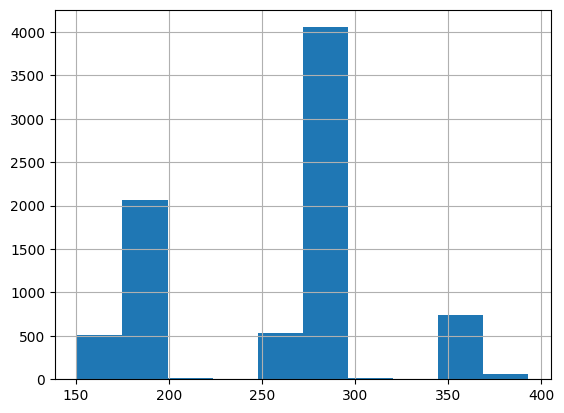

col:  IURL


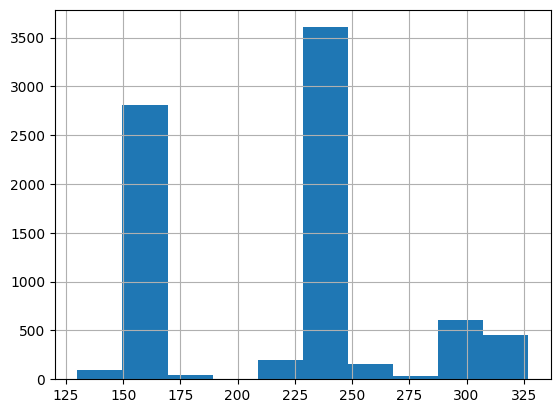

col:  EURL


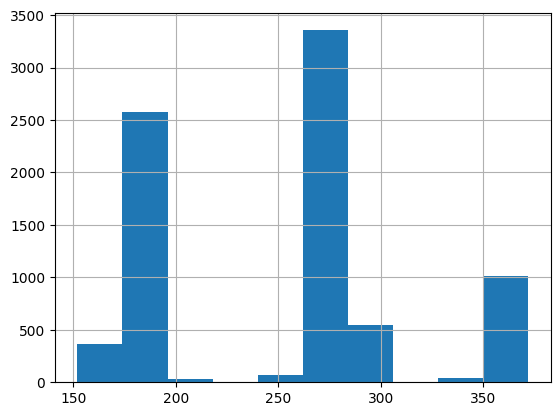

col:  IURR


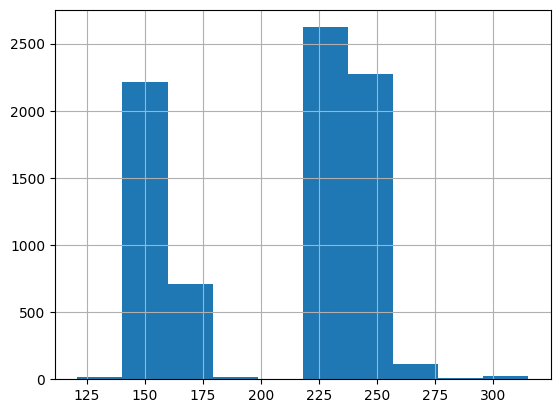

col:  EURR


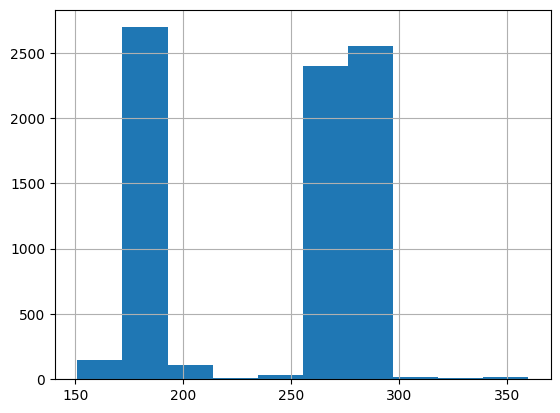

col:  Temperature


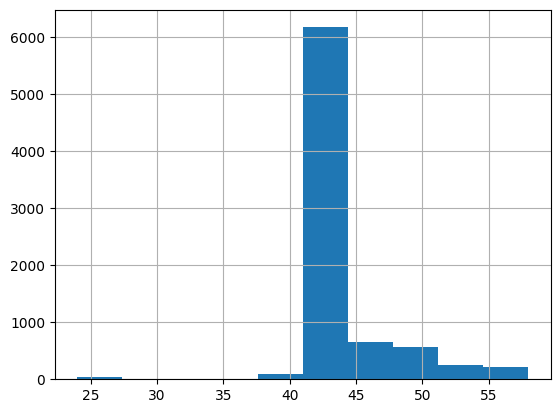

col:  Health_Mastitis


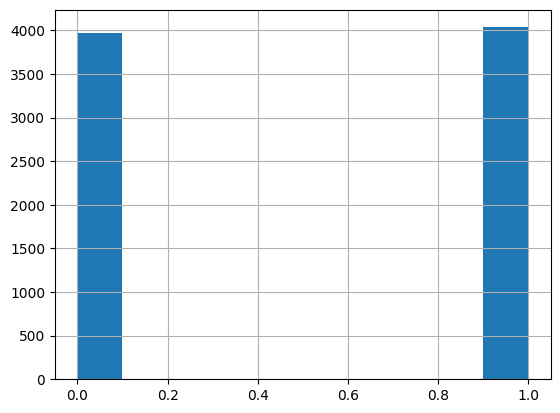

In [8]:
import matplotlib.pyplot as plt

columns = df.columns
for col in columns:
    print("col: ", col)
    df[col].hist()
    plt.show()

In [9]:
# Split data into training, test, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

print("Training set size:", X_train.shape[0], "or", round(X_train.shape[0]/x.shape[0]*100, 1), "%")
print("Test set size:", X_test.shape[0], "or", round(X_test.shape[0]/x.shape[0]*100, 1), "%")
print("Validation set size:", X_val.shape[0], "or", round(X_val.shape[0]/x.shape[0]*100, 1), "%")

Training set size: 5598 or 70.0 %
Test set size: 1608 or 20.1 %
Validation set size: 792 or 9.9 %


In [10]:
# Reshape the input data for LSTM (samples, time steps, features)
n_features = X_train.shape[1]
X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, n_features))
X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, n_features))
X_val_reshaped = X_val.values.reshape((X_val.shape[0], 1, n_features))

X_val_reshaped

array([[[  4, 165, 196, ..., 166, 194,  24]],

       [[  4, 159, 192, ..., 151, 187,  43]],

       [[  1, 233, 273, ..., 233, 273,  43]],

       ...,

       [[  2, 162, 193, ..., 163, 191,  43]],

       [[  6, 154, 184, ..., 153, 183,  43]],

       [[  4, 242, 271, ..., 242, 271,  43]]])

In [11]:
import tensorflow as tf
from tensorflow.keras.losses import binary_crossentropy
# Define the custom loss function
def custom_loss(y_true, y_pred, temperature, threshold=42, penalty_factor=2.0):
    # Apply penalty if temperature exceeds the threshold
    penalty = tf.where(temperature > threshold, penalty_factor, 1.0)
    # Compute binary cross-entropy loss
    bce = binary_crossentropy(y_true, y_pred)
    # Apply the penalty to the loss
    loss = tf.reduce_mean(penalty * bce)
    return loss


In [12]:
# Define and compile the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(1, n_features)),
    LSTM(50),
    Dense(1, activation='sigmoid')
])

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


In [13]:
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Compile the model with a wrapper to include temperature in the loss calculation
temperature_feature_index = 9  #  temperature is the 10th feature

model.compile(optimizer='adam', 
              loss=lambda y_true, y_pred: custom_loss(y_true, y_pred, X_train_reshaped[:,:,temperature_feature_index]), 
              metrics=['accuracy'])




In [14]:
# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=50,  validation_data=(X_val_reshaped, y_val))

Epoch 1/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7649 - loss: 1.1464 - val_accuracy: 0.8523 - val_loss: 0.7218
Epoch 2/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8615 - loss: 0.7143 - val_accuracy: 0.8573 - val_loss: 0.6896
Epoch 3/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8686 - loss: 0.6619 - val_accuracy: 0.8586 - val_loss: 0.7409
Epoch 4/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8638 - loss: 0.6665 - val_accuracy: 0.8561 - val_loss: 0.6932
Epoch 5/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8617 - loss: 0.6733 - val_accuracy: 0.8561 - val_loss: 0.6948
Epoch 6/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8558 - loss: 0.6806 - val_accuracy: 0.8561 - val_loss: 0.7116
Epoch 7/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8601 - loss: 0.6770 - val_accuracy: 0.8586 - val_loss: 0.6985
Epoch 8/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8698 - loss: 0.6445 - val_accuracy: 0.

In [15]:
# Train the model
#history = model.fit(X_train_reshaped, y_train, epochs=50, validation_data=(X_val_reshaped, y_val))

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 50)          │        12,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,355 (380.30 KB)

 Trainable params: 32,451 (126.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 64,904 (253.54 KB)

In [17]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test)
print("Test Accuracy:", test_acc)

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7204 - loss: 0.9977
Test Accuracy: 0.7276119589805603


In [18]:
# Making predictions
predictions = model.predict(X_test_reshaped)
binary_predictions = (predictions > 0.5).astype(int)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [19]:
import pandas as pd

# Assuming 'predictions' are in the format returned by model.predict() and are probabilities
# Flatten the predictions array and round them off for better readability
predicted_probs = predictions.flatten().round(2)

# Create a DataFrame from the test set features
test_features = pd.DataFrame(X_test_reshaped.reshape(X_test_reshaped.shape[0], n_features), columns=X_test.columns)

# Add the predictions and the actual labels to the DataFrame
test_features['Predicted Probability'] = predicted_probs
test_features['Actual Label'] = y_test  

# Sort the DataFrame by 'Predicted Probability' to get the top predictions
test_features_sorted = test_features.sort_values(by='Predicted Probability', ascending=False)

In [20]:
# Display the top 5 predictions
top_5_predictions = test_features_sorted.head(5)
print(top_5_predictions)

      Months_after_giving_birth  IUFL  EUFL  IUFR  EUFR  IURL  EURL  IURR  \
1266                          3   234   278   233   279   302   353   238   
249                           4   233   276   235   273   302   363   232   
472                           4   158   185   333   389   151   190   155   
1399                          3   312   362   151   181   151   182   152   
1252                          2   234   273   243   279   305   357   234   

      EURR  Temperature  Predicted Probability  Actual Label  
1266   277           43                    1.0             1  
249    270           43                    1.0             1  
472    189           45                    1.0             1  
1399   181           52                    1.0             1  
1252   277           48                    1.0             1  


In [21]:
top_5_predictions.to_csv("top_5_predictions_v1.0.csv", index=False)
top_5_predictions.info

<bound method DataFrame.info of       Months_after_giving_birth  IUFL  EUFL  IUFR  EUFR  IURL  EURL  IURR  \
1266                          3   234   278   233   279   302   353   238   
249                           4   233   276   235   273   302   363   232   
472                           4   158   185   333   389   151   190   155   
1399                          3   312   362   151   181   151   182   152   
1252                          2   234   273   243   279   305   357   234   

      EURR  Temperature  Predicted Probability  Actual Label  
1266   277           43                    1.0             1  
249    270           43                    1.0             1  
472    189           45                    1.0             1  
1399   181           52                    1.0             1  
1252   277           48                    1.0             1  >

In [22]:
# Convert probabilities to binary predictions
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

In [23]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions)

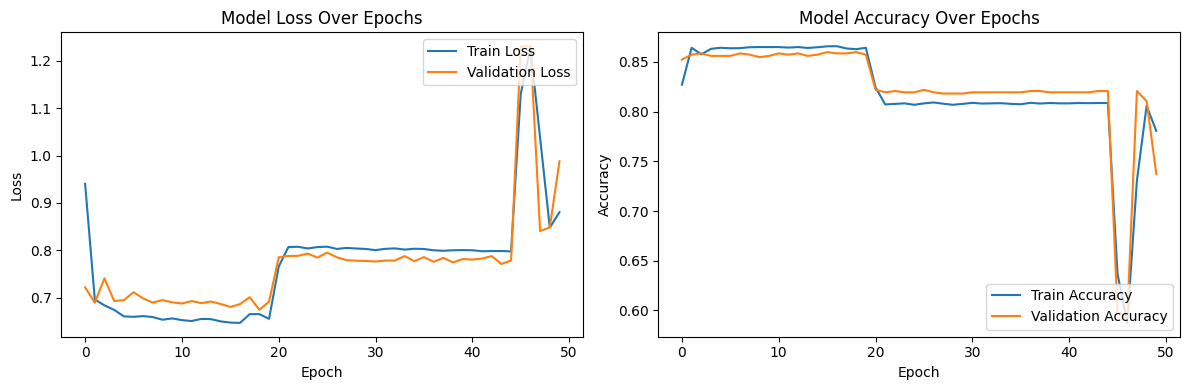

In [24]:
# Plot training & validation loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


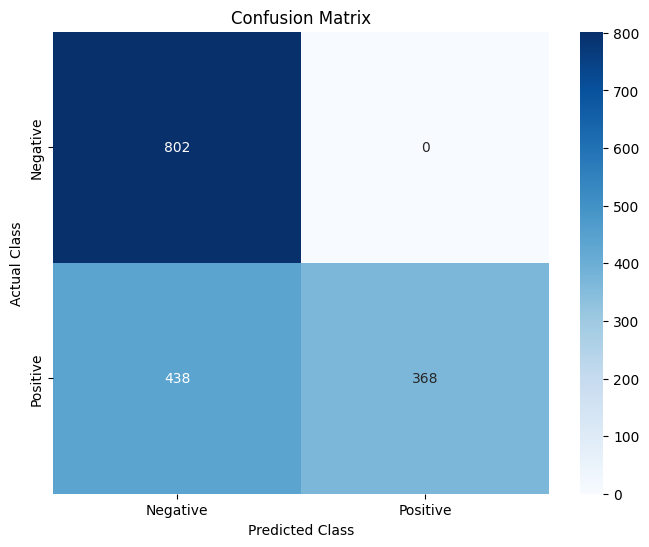

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the labels for the confusion matrix (adjust labels for your specific case)
labels = ['Negative', 'Positive']

# Create a heatmap from the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics
accuracy = accuracy_score(y_test, binary_predictions)
precision = precision_score(y_test, binary_predictions)
recall = recall_score(y_test, binary_predictions)
f1 = f1_score(y_test, binary_predictions)

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.7276119402985075
Precision: 1.0
Recall: 0.456575682382134
F1 Score: 0.626916524701874


51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


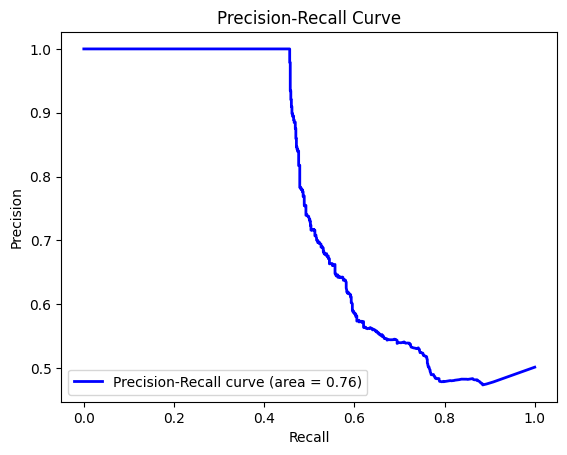

In [27]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Predict probabilities
y_pred_prob = model.predict(X_test_reshaped).ravel()
# Compute precision-recall pairs for different probability thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Compute average precision score
average_precision = average_precision_score(y_test, y_pred_prob)

# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, color='b', lw=2, label=f'Precision-Recall curve (area = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

True Negatives (TN): 802
False Positives (FP): 0
False Negatives (FN): 438
True Positives (TP): 368


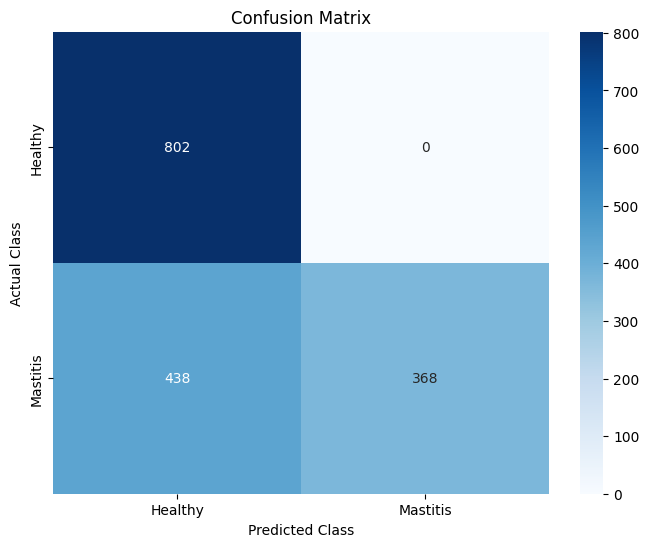

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming binary_predictions and y_test are already defined

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions)

# Extract TN, FP, FN, TP
TN, FP, FN, TP = conf_matrix.ravel()

# Print TN, FP, FN, TP
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Positives (TP): {TP}")

# Optional: Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=['Healthy', 'Mastitis'], yticklabels=['Healthy', 'Mastitis'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


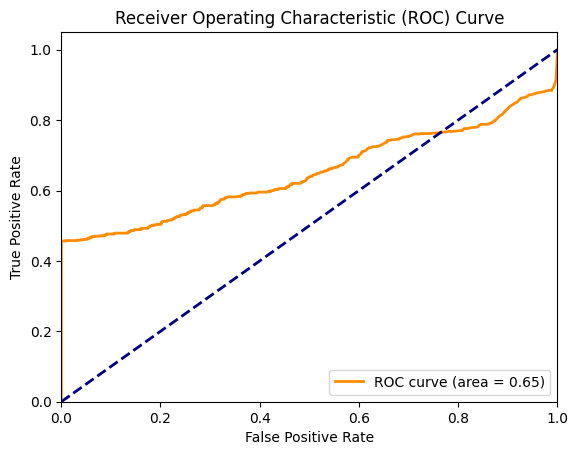

In [29]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities
y_pred_prob = model.predict(X_test_reshaped).ravel()

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [30]:
# Save the entire model
model.save('lstm_model.h5')